In [ ]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.stem.porter import *
from nltk.corpus import stopwords 
import string
import re
"""from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS"""
"""from textstat.textstat import *"""
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
import seaborn
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
http_dataset = 'https://github.com/korentomas/dhdesafio3/raw/main/datasentiment.zip'
df = pd.read_csv(http_dataset,low_memory=False, encoding="utf-8")

In [ ]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### target: the polarity of the tweet (0 = negative, 4 = positive)

In [ ]:
df.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [ ]:
df.target = df.target.replace([4, 0], ['POS', 'NEG'])

In [ ]:
df = df[['target','text']]
df.head()

,target,text
0,NEG,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEG,is upset that he can't update his Facebook by ...
2,NEG,@Kenichan I dived many times for the ball. Man...
3,NEG,my whole body feels itchy and like its on fire
4,NEG,"@nationwideclass no, it's not behaving at all...."


#Preprocesamiento del texto

In [ ]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """#
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [ ]:
remueve entre otras cosas múltiples espacios en blanco, saltos de línea, símbolo “#”, emojis, url’s##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

In [ ]:
df['text_clean'] = texts_new

In [ ]:
df.head()

,target,text
0,NEG,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEG,is upset that he can't update his Facebook by ...
2,NEG,@Kenichan I dived many times for the ball. Man...
3,NEG,my whole body feels itchy and like its on fire
4,NEG,"@nationwideclass no, it's not behaving at all...."


In [ ]:
X,y =df['text_clean'], df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,2), stop_words= 'english', sublinear_tf=True)),
                    ('chi', SelectKBest(chi2, k=10000)),
                     ('clf', LinearSVC(C=1.0, penalty='l1',max_iter=3000, dual=False))
                    ])


pipeline.get_params

NameError: ignored

In [ ]:
calibrated_pipeline = CalibratedClassifierCV(pipeline)
calibrated_pipeline.get_params

<bound method BaseEstimator.get_params of CalibratedClassifierCV(base_estimator=Pipeline(steps=[('vect',
                                                       TfidfVectorizer(ngram_range=(1,
                                                                                    2),
                                                                       stop_words='english',
                                                                       sublinear_tf=True)),
                                                      ('chi',
                                                       SelectKBest(k=10000,
                                                                   score_func=<function chi2 at 0x7f87ef232d40>)),
                                                      ('clf',
                                                       LinearSVC(dual=False,
                                                                 max_iter=3000,
                                                               

In [ ]:
print(f"TRAINING DATA: {X_train.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 1280000
TESTING DATA: 320000


In [ ]:
model = pipeline.fit(X_train, y_train)

In [ ]:
model_2 = calibrated_pipeline.fit(X_train, y_train)

In [ ]:
print('accuracy score: '+ str(model.score(X_test, y_test)))

accuracy score: 0.77403125


In [ ]:
print('accuracy score: '+ str(model_2.score(X_test, y_test)))

accuracy score: 0.77554375


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


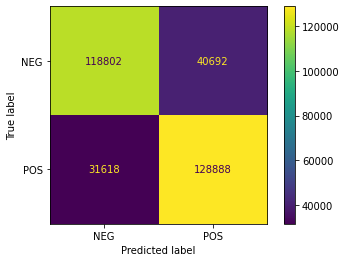

In [ ]:
plot_confusion_matrix(model, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


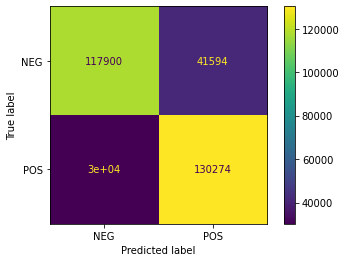

In [ ]:
plot_confusion_matrix(model_2, X_test, y_test)

In [ ]:
model.predict((['I am graduating from Digital House']))

array(['POS'], dtype=object)

In [ ]:
model_2.predict((['I am graduating from Digital House']))

array(['POS'], dtype=object)

In [ ]:
model.predict((['I failed the last workshop']))

array(['NEG'], dtype=object)

In [ ]:
model_2.predict((['I failed the last workshop']))

array(['NEG'], dtype=object)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         NEG       0.79      0.74      0.77    159494
         POS       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [ ]:
import joblib 

joblib.dump(model, 'sentiment-model.pkl')

['sentiment-model.pkl']

In [ ]:
classifier213 = joblib.load('sentiment-model.pkl')

In [ ]:
import joblib
classifier213 = joblib.load('sentiment-model.pkl')
classifier213.predict(['tengo mucho calor'])

array(['POS'], dtype=object)

In [ ]:
classifier213.predict(['I hate summer'])

array(['NEG'], dtype=object)

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model_2.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds, pos_label='POS')
roc_auc = metrics.auc(fpr, tpr)

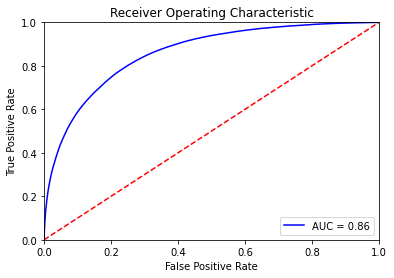

In [ ]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle = False)
roc_auc = cross_val_score(model, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()
roc_auc

0.8560624310834137

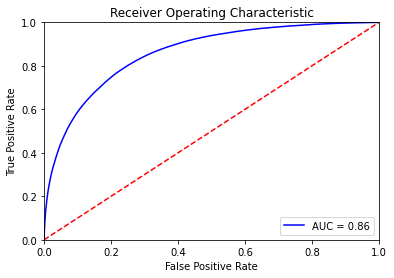

In [ ]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()